2025-08-01 15:26:36 — INFO — Notebook start.
2025-08-01 15:26:36 — INFO — Installing python-dotenv (missing)
2025-08-01 15:26:37 — INFO — Installing Pillow (missing)
2025-08-01 15:26:40 — INFO — GenAI backend: Dev API
2025-08-01 15:26:40 — INFO — ISIC 2017 dataset found at D:\Projects\gemini_image_segmentation\data\ISIC_2017_Part1
2025-08-01 15:26:40 — INFO — 2750 paired images collected.
2025-08-01 15:26:40 — INFO — Selected sample image: ISIC_0010344.jpg
2025-08-01 15:26:40 — INFO — Starting Gemini API call.
2025-08-01 15:26:40 — INFO — AFC is enabled with max remote calls: 10.
2025-08-01 15:26:42 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-08-01 15:26:42 — INFO — AFC remote call 1 is done.
2025-08-01 15:26:42 — INFO — Gemini latency 1.71s
2025-08-01 15:26:42 — INFO — Received response from Gemini. Parsing masks...
2025-08-01 15:26:42 — INFO — Found 1 segmentation masks.
C:\Users\steal\App

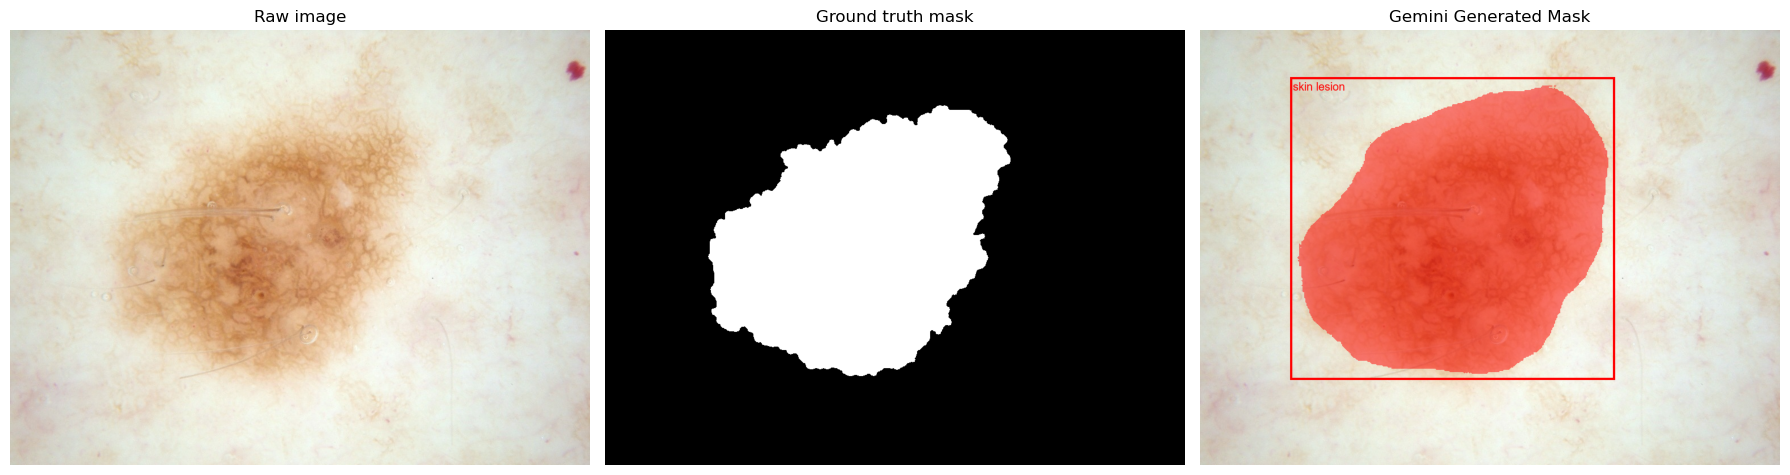

2025-08-01 15:26:42 — INFO — Saved pilot list for evaluation to D:\Projects\gemini_image_segmentation\data\ISIC_2017_Part1\pilot50_isic.txt


'\n✅ Environment verified, ISIC 2017 dataset indexed, Gemini smoke-test executed with correct parsing logic.\nNext step: Run a batch evaluation on **pilot50_isic.txt**.\n'

In [1]:
# %% [markdown]
"""
# 01 Environment & Data Prep · **ISIC 2017 Edition** (uses `environment.yml`)

*Last sync 01 Aug 2025* This script adapts the original segmentation workflow for the ISIC 2017
skin lesion dataset. It calls the Gemini API to identify and mask lesions in images.
- `gemini-2.5-flash` model
- Thinking disabled (`thinking_budget=0`)
- A clear, conversational prompt requesting a JSON list of masks.
- **Correctly parses the API's output of partial masks within bounding boxes.**
- **Visualizes the final masks overlaid on the original image.**

**Changelog (Adapted for ISIC 2017)**
* **MODIFIED** dataset paths to point to the ISIC 2017 data structure (`data/ISIC_2017_Part1/`).
* **MODIFIED** the image-mask pairing logic to handle ISIC's naming convention (`..._Segmentation.png`).
* **UPDATED** the `PROMPT` to request segmentation of "the skin lesion" instead of polyps.
* **RENAMED** variables and log messages for clarity (e.g., `hk_dir` -> `dataset_dir`).
* **RETAINED** the core modular structure for API calls, parsing, and visualization.
"""

# %%
# ---------- Preamble
import sys, logging, os, subprocess, importlib.util, json, io, random, base64, dataclasses
from datetime import datetime
from pathlib import Path
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor, UnidentifiedImageError

assert sys.version_info >= (3, 11), (
    f"Python 3.11+ required, found {sys.version.split()[0]}")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.info("Notebook start.")

# %%
# ---------- Ensure helper packages

def _ensure(pkg: str):
    """Checks if a package is installed and installs it if not."""
    if importlib.util.find_spec(pkg) is None:
        logging.info("Installing %s (missing)", pkg)
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for extra in ("python-dotenv", "tqdm", "matplotlib", "numpy", "Pillow"):
    _ensure(extra)

# %%
# ---------- GenAI client
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=False)

from google import genai
from google.genai.types import GenerateContentConfig, Part, ThinkingConfig

if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY not found. Ensure it is in your .env file.")

client = genai.Client()
logging.info("GenAI backend: %s", "Vertex" if client.vertexai else "Dev API")

# %%
# ---------- Dataset paths
# MODIFIED: Point to the ISIC 2017 dataset directory.
dataset_dir = Path("data/ISIC_2017_Part1").expanduser().resolve()
image_subdir = dataset_dir / "image"
mask_subdir = dataset_dir / "mask"

if not (dataset_dir.is_dir() and image_subdir.is_dir() and mask_subdir.is_dir()):
    logging.error("Dataset not found or incomplete at the specified path.")
    raise FileNotFoundError(
        f"Expected 'image/' & 'mask/' subdirectories inside {dataset_dir}. "
        "Please ensure the ISIC 2017 dataset is correctly placed."
    )
logging.info("ISIC 2017 dataset found at %s", dataset_dir)


# %%
# ---------- Collect pairs
# MODIFIED: Logic to handle the ISIC naming convention (e.g., ISIC_0000000.jpg -> ISIC_0000000_Segmentation.png)
dataset = []
img_paths = sorted(image_subdir.glob("*.jpg"))
for img_path in img_paths:
    mask_name = f"{img_path.stem}_Segmentation.png"
    mask_path = mask_subdir / mask_name
    if mask_path.exists():
        dataset.append((img_path, mask_path))

assert dataset, "No image-mask pairs found in the dataset!"
logging.info("%d paired images collected.", len(dataset))


# %%
# ---------- Segmentation Utils

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """A dataclass to hold a single segmentation mask's data."""
    y0: int
    x0: int
    y1: int
    x1: int
    mask: np.ndarray # Full-size mask [img_height, img_width] with values 0..255
    label: str

def parse_json(json_output: str) -> str:
    """Cleans the model's JSON output by removing markdown fencing."""
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line.strip() == "```json":
            json_content = "\n".join(lines[i+1:])
            closing_fence_index = json_content.find("```")
            if closing_fence_index != -1:
                json_content = json_content[:closing_fence_index]
            return json_content.strip()
    return json_output.strip()

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> list[SegmentationMask]:
    """Parses the model's JSON output into a list of SegmentationMask objects."""
    cleaned_json = parse_json(predicted_str)
    if not cleaned_json:
        logging.warning("Parsing model output resulted in an empty string.")
        return []

    try:
        items = json.loads(cleaned_json)
    except json.JSONDecodeError as e:
        logging.error(f"Failed to decode JSON: {e}")
        logging.error(f"Problematic string after cleaning: {cleaned_json}")
        return []

    masks = []
    for item in items:
        try:
            abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
            abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
            abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
            abs_x1 = int(item["box_2d"][3] / 1000 * img_width)

            if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
                logging.warning("Skipping item with invalid bounding box: %s", item["box_2d"])
                continue

            label = item["label"]
            png_b64_str = item["mask"]

            if not png_b64_str.startswith("data:image/png;base64,"):
                logging.warning("Skipping item with invalid mask format for label '%s'", label)
                continue

            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            partial_mask_img = Image.open(io.BytesIO(png_bytes))

            bbox_height = abs_y1 - abs_y0
            bbox_width = abs_x1 - abs_x0
            if bbox_height < 1 or bbox_width < 1:
                logging.warning("Skipping item with zero-area bounding box for label '%s'", label)
                continue

            resized_mask = partial_mask_img.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
            full_mask_np = np.zeros((img_height, img_width), dtype=np.uint8)
            full_mask_np[abs_y0:abs_y1, abs_x0:abs_x1] = np.array(resized_mask)

            masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, full_mask_np, label))
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError) as e:
            logging.error(f"Skipping malformed item in JSON response: {item}. Error: {e}")
            continue
    return masks

def overlay_mask_on_img(img: Image.Image, mask: np.ndarray, color: str, alpha: float = 0.5) -> Image.Image:
    """Overlays a single mask onto a PIL Image."""
    color_rgb = ImageColor.getrgb(color)
    img_rgba = img.convert("RGBA")
    overlay_color_rgba = color_rgb + (int(alpha * 255),)

    colored_mask_layer_np = np.zeros((img.height, img.width, 4), dtype=np.uint8)
    mask_binary = mask > 127
    colored_mask_layer_np[mask_binary] = overlay_color_rgba
    colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np, 'RGBA')

    return Image.alpha_composite(img_rgba, colored_mask_layer_pil)

def plot_segmentation_masks(img: Image.Image, segmentation_masks: list[SegmentationMask]) -> Image.Image:
    """Draws all masks, bounding boxes, and labels on an image."""
    if not segmentation_masks:
        return img.convert("RGB")

    colors = ["red", "green", "blue", "yellow", "purple", "orange", "cyan", "magenta"]
    try:
        font = ImageFont.truetype("arial.ttf", size=20)
    except IOError:
        logging.warning("Arial font not found, using default. Labels may be small.")
        font = ImageFont.load_default()

    img_with_masks = img.copy()
    for i, seg_mask in enumerate(segmentation_masks):
        color = colors[i % len(colors)]
        img_with_masks = overlay_mask_on_img(img_with_masks, seg_mask.mask, color)

    draw = ImageDraw.Draw(img_with_masks)
    for i, seg_mask in enumerate(segmentation_masks):
        color = colors[i % len(colors)]
        box = ((seg_mask.x0, seg_mask.y0), (seg_mask.x1, seg_mask.y1))
        draw.rectangle(box, outline=color, width=4)
        if seg_mask.label:
            text_position = (seg_mask.x0 + 5, seg_mask.y0 + 5)
            draw.text(text_position, seg_mask.label, fill=color, font=font)

    return img_with_masks.convert("RGB")


# %%
# ---------- Gemini smoke-test (Refactored)

MODEL_NAME = "gemini-2.5-flash"
# MODIFIED: Prompt updated for skin lesion segmentation.
PROMPT = (
    'Give the segmentation masks for the skin lesion. '
    'Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key "box_2d", '
    'the segmentation mask in key "mask", and the text label in the key "label". '
    'Use descriptive labels like "melanoma", "nevus", or "seborrheic keratosis".'
)

def gemini_seg(image_obj: Image.Image) -> Tuple[list[SegmentationMask], float]:
    """
    Sends a PIL Image object to Gemini and returns a list of SegmentationMasks.

    Args:
        image_obj: A PIL.Image.Image object to be segmented.

    Returns:
        A tuple containing:
        - A list of SegmentationMask objects.
        - The latency of the API call in seconds.
    """
    logging.info("Starting Gemini API call.")
    original_width, original_height = image_obj.size
    
    try:
        # 1. Copy the image to avoid modifying the original object
        img_for_api = image_obj.copy()

        # 2. Resize for the API call if necessary
        max_dim = 1024
        if img_for_api.height > max_dim or img_for_api.width > max_dim:
            img_for_api.thumbnail((max_dim, max_dim))
            logging.info(f"Resized image from {original_width}x{original_height} to {img_for_api.size} for API call.")

        # 3. Convert the (potentially resized) PIL image to bytes
        with io.BytesIO() as img_byte_arr:
            img_for_api.save(img_byte_arr, format='JPEG')
            img_bytes = img_byte_arr.getvalue()

        # 4. Define the generation configuration
        gen_config = GenerateContentConfig(
            thinking_config=ThinkingConfig(thinking_budget=0),
            temperature=0.5
        )

        # 5. Create explicit Part objects for the request
        image_part = Part.from_bytes(data=img_bytes, mime_type='image/jpeg')
        text_part = Part(text=PROMPT)

        # 6. Send the request
        start_time = datetime.now()
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=[image_part, text_part],
            config=gen_config,
        )
        latency = (datetime.now() - start_time).total_seconds()
        logging.info("Gemini latency %.2fs", latency)

        # 7. Parse the response using the utility function
        logging.info("Received response from Gemini. Parsing masks...")
        masks = parse_segmentation_masks(
            response.text,
            img_height=original_height,
            img_width=original_width
        )
        logging.info("Found %d segmentation masks.", len(masks))
        return masks, latency

    except Exception as e:
        logging.error("An error occurred during the gemini_seg function.", exc_info=True)
        return [], 0.0

# %%
# ---------- Main Execution and Visualization ----------
# Select a random sample and open the image ONCE.
sample_img_path, sample_mask_path = random.choice(dataset)
logging.info("Selected sample image: %s", sample_img_path.name)
original_image = Image.open(sample_img_path)

# Execute the segmentation by passing the Image object
gemini_masks, _ = gemini_seg(original_image)

# Visualize the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# 1. Original Image
ax[0].imshow(original_image)
ax[0].set_title("Raw image")
ax[0].axis("off")

# 2. Ground Truth Mask
try:
    # ISIC masks are single channel, convert to RGB for consistent display
    ground_truth_mask = Image.open(sample_mask_path).convert("RGB")
    ax[1].imshow(ground_truth_mask)
    ax[1].set_title("Ground truth mask")
except FileNotFoundError:
    ax[1].text(0.5, 0.5, 'Mask Not Found', ha='center', va='center')
    ax[1].set_title("Ground truth mask (not found)")
ax[1].axis("off")

# 3. Gemini Generated Mask
if gemini_masks:
    composite_image = plot_segmentation_masks(original_image, gemini_masks)
    ax[2].imshow(composite_image)
    ax[2].set_title("Gemini Generated Mask")
else:
    ax[2].imshow(original_image)
    ax[2].text(0.5, 0.5, 'Mask Generation Failed', ha='center', va='center', color='red',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    ax[2].set_title("Gemini (failed)")
ax[2].axis("off")

plt.tight_layout()
plt.show()


# %%
# ---------- Save pilot list (for batch evaluation)
# This part of the script prepares a list for a larger evaluation run.
random.seed(42)
pilot_paths = [p for p, _ in random.sample(dataset, min(50, len(dataset)))]
if pilot_paths:
    # MODIFIED: Filename updated for the ISIC dataset.
    pilot_list_path = dataset_dir / "pilot50_isic.txt"
    pilot_list_path.write_text("\n".join(str(p) for p in pilot_paths))
    logging.info(f"Saved pilot list for evaluation to {pilot_list_path}")

# %% [markdown]
"""
✅ Environment verified, ISIC 2017 dataset indexed, Gemini smoke-test executed with correct parsing logic.
Next step: Run a batch evaluation on **pilot50_isic.txt**.
"""
